In [1]:
import numpy as np
from PadeSolve import PadeSolve
from CRAMsolve import CRAM16
from RKsolve import RK45solve_full_trajectory
from scipy.integrate import RK45
from scipy.sparse import csc_matrix, issparse, save_npz, load_npz
import time
import sys
import matplotlib.pyplot as plt

from reduce_stiffness import reduce_stiffness

np.set_printoptions(precision = 2)

# Small decay matrix

Reading A matrix from /psi/home/albajacas_a/data/phd/pxs/jiri_matrices_for_python/dummy_3x3_matrix.npz
Matrix A:
 [[-5  0  0]
 [ 5 -3  0]
 [ 0  3  0]]




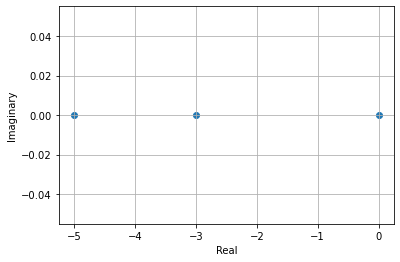

eigvals [ 0. -3. -5.]


In [279]:
fn = "/psi/home/albajacas_a/data/phd/pxs/jiri_matrices_for_python/dummy_3x3_matrix.npz"
print("Reading A matrix from", fn)
A = load_npz(fn)
n = A.shape[0]
print("Matrix A:\n", A.toarray())
print("\n")

N0 = [10.0, 0,0]
assert len(N0) == n

t = 3.5
A = csc_matrix(A) if not issparse(A) else A  # Make A sparse if it wasn't already.

eigs = np.linalg.eig(A.toarray())[0]
plt.scatter([eig.real for eig in eigs], [eig.imag for eig in eigs])
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.grid()
plt.show()
print("eigvals", eigs)

In [280]:
# RK45
# RK45
tsRK, NsRK = RK45solve_full_trajectory(A,N0,t,atol = 1e-8, rtol = 1e-8)

# CRAM
nstep = 50
ts = np.linspace(0,t,nstep)
NsCRAM = np.zeros([nstep, n])
for i in range(nstep):
    NsCRAM[i,:] = CRAM16(A,N0,ts[i])
    
# Padé
NsPade = np.zeros([nstep, n])
for i in range(nstep):
    NsPade[i,:] = PadeSolve(A,N0,ts[i])

['N0->black', 'N1->blue', 'N2->red', 'N3->green']


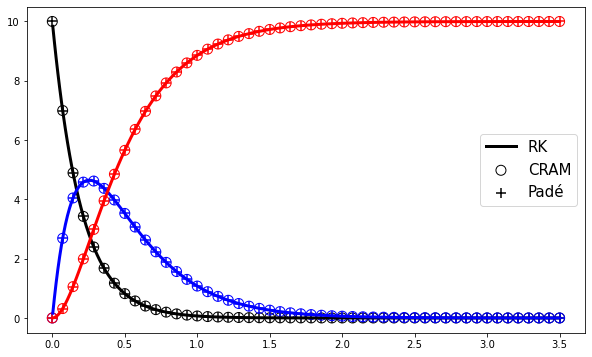

In [281]:
fig, ax = plt.subplots(figsize = (10,6))
colors = ["black", "blue", "red", "green"]
print(["N" + str(i) + "->" + colors[i] for i,_ in enumerate(colors)])

for i in range(n):
    ax.plot(tsRK, NsRK[:,i], lw = 3, ls = "-", color = colors[i])
    ax.scatter(ts, NsCRAM[:,i], marker = "o", color = colors[i], facecolors = 'none', s = 100)
    ax.scatter(ts, NsPade[:,i], marker = "+", color = colors[i], s = 100)
    
ax.legend(["RK", "CRAM", "Padé"], fontsize = 15)
# ax.set_xscale("log");ax.set_yscale("log")
plt.show()

# Small matrix: case where CRAM fails

Matrix A:
 [[ -1   0   0   0 200]
 [  1  -1   0   0   0]
 [  0   1  -1   0   0]
 [  0   0   1  -1   0]
 [  0   0   0   1  -1]]




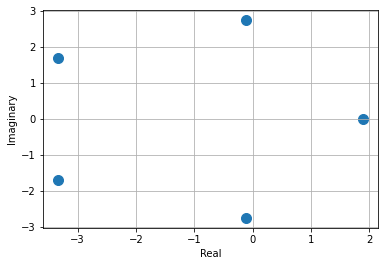

eigvals [-3.33433748+1.69599546j -3.33433748-1.69599546j -0.10836242+2.74417829j
 -0.10836242-2.74417829j  1.88539981+0.j        ]


In [353]:

# Note: this is not a real burnup matrix, since all columns should add to zero.

A = np.array([[-1,0,0,0,200],
              [1,-1,0,0,0],
              [0,1,-1,0,0],
              [0,0,1,-1,0],
              [0,0,0,1,-1]
             ])

n = A.shape[0]
print("Matrix A:\n", A)
print("\n")

N0 = [0.0, 0, 0, 0, 1]
assert len(N0) == n
for i in range(n):
    if np.sum(A[:,i]) != 0:
        print("Warning: Failed with column {:d}. Sum is {:.2f}".format(i,np.sum(A[:,i])))

t = 3.5
A = csc_matrix(A) if not issparse(A) else A  # Make A sparse if it wasn't already.

eigs = np.linalg.eig(A.toarray())[0]
plt.scatter([eig.real for eig in eigs], [eig.imag for eig in eigs], marker = "o", s = 100)
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.grid()
plt.show()
print("eigvals", eigs)

In [354]:
# RK45
tsRK, NsRK = RK45solve_full_trajectory(A,N0,t,atol = 1e-8, rtol = 1e-8)

# CRAM
nstep = 100
ts = np.linspace(0,t,nstep)
NsCRAM = np.zeros([nstep, n])
for i in range(nstep):
    NsCRAM[i,:] = CRAM16(A,N0,ts[i])
    
# Padé
NsPade = np.zeros([nstep, n])
for i in range(nstep):
    NsPade[i,:] = PadeSolve(A,N0,ts[i])

['N0->black', 'N1->blue', 'N2->red', 'N3->green', 'N4->pink']


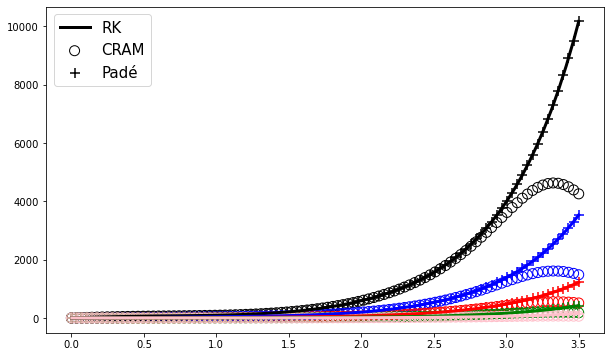

In [355]:
fig, ax = plt.subplots(figsize = (10,6))
colors = ["black", "blue", "red", "green", "pink", "yellow"]
print(["N" + str(i) + "->" + colors[i] for i in range(n)])

for i in range(n):
    ax.plot(tsRK, NsRK[:,i], lw = 3, ls = "-", color = colors[i])
    ax.scatter(ts, NsCRAM[:,i], marker = "o", color = colors[i], facecolors = 'none', s = 100)
    ax.scatter(ts, NsPade[:,i], marker = "+", color = colors[i], s = 100)
    
ax.legend(["RK", "CRAM", "Padé"], fontsize = 15)
# ax.set_xscale("log");ax.set_yscale("log")
# ax.set_xlim(left = -.001, right = .1)
# ax.set_ylim(top = 510)
plt.show()

# Test medium size matrices

## Pu241 decay

In [2]:
fn = "Pu241_decay_n=5.npz"
print("Reading A matrix from", fn)
A = load_npz(fn)
n = A.shape[0]
print("Matrix A:\n", A.toarray())
print("\n")

nucs = ['Pu241', 'U237', 'Am241', 'Np237', 'Pa233', 'U233'] 

N0 = np.zeros(A.shape[0])
N0[0] = 1.0

Reading A matrix from Pu241_decay_n=5.npz
Matrix A:
 [[-2.22e-09  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 5.43e-14 -1.71e-06  0.00e+00  0.00e+00  0.00e+00]
 [ 2.22e-09  0.00e+00 -7.33e-11  0.00e+00  0.00e+00]
 [ 0.00e+00  1.71e-06  7.33e-11 -1.48e-14  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.48e-14 -4.29e-07]]




In [3]:
year = 365*24*3600
t_final = 800 * year
tsRK, NsRK = RK45solve_full_trajectory(A,N0,t_final,atol = 1e-8, rtol = 1e-8)

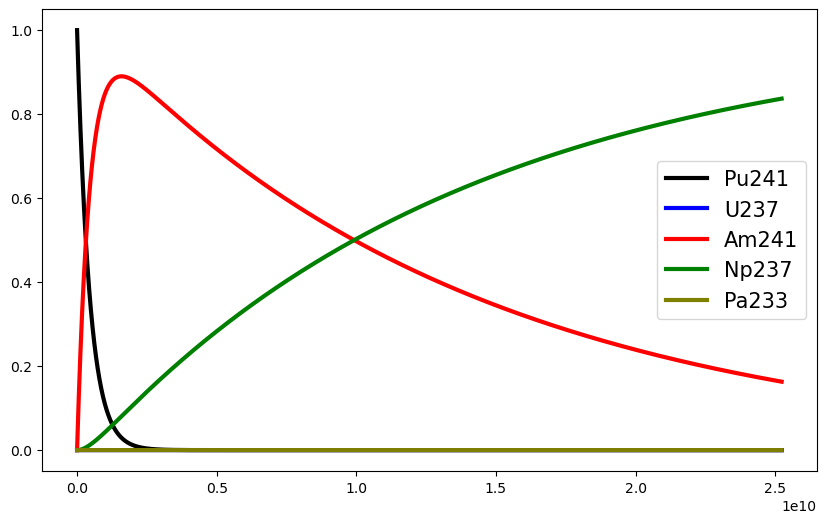

In [4]:
fig, ax = plt.subplots(figsize = (10,6))
colors = ["black", "blue", "red", "green", "olive", "pink", "yellow"]

for i in range(n):
    ax.plot(tsRK, NsRK[:,i], lw = 3, ls = "-", color = colors[i])
    
ax.legend(nucs, fontsize = 15)
# ax.set_xscale("log");ax.set_yscale("log")
# ax.set_xlim(left = -.001, right = .1)
# ax.set_ylim(top = 510)
plt.show()

## Make the system progressively stiffer? Is it possible?

In [83]:
# def reduce_stiffness(A, stiff):
#     '''
#     Returns matrix A, where the stiffness has been reduced.
#     This is achieved by scaling the columns.
#     Overall it is ensured that the stiffness ratio |λ_max| / |λ_min| = stiff.
    
#     A : matrix or sparse matrix. It is assumed that the eigvals of A are its diagonal!
#     (i.e. A is assumed to be triangular or permutable to triangular)
#     stiff : float. Desired stiffness
#     '''

#     A = A.toarray() if issparse(A) else A
#     n = A.shape[0]

#     lams = np.abs(A.diagonal())
#     lams = lams[lams != 0]
#     true_stiff = lams.max() / lams.min()
#     if stiff >= true_stiff:
#         print('required stiffness is larger than current stiffness. Returning A as is.')
#         return A
    
#     lmax = lams.max()
#     lmin = lams.min()
#     lmax_new = lmin * stiff
#     lams_scaled = (lams - lmin) / (lmax - lmin) * (lmax_new - lmin) + lmin
#     scale_matrix = np.diag(lams_scaled / lams)
    
#     # v2
#     # We want to bring both very small and very large eigvals closer to the median eigval.
#     # stiff = sqrt(stiff)^2 = lmax/lmin = lmax/lmed * lmed/lmin <= lmax/lmed = lmed/lmin = sqrt(stiff)
# #     lmax = lams.max()
# #     lmin = lams.min()
# #     lmed = np.median(lams)
# #     lmax_new = lmed * np.sqrt(stiff)
# #     lmin_new = lmed / np.sqrt(stiff)
# #     lams_scaled = (lams - lmin) / (lmax - lmin) * (lmax_new - lmin_new) + lmin_new
# #     scale_matrix = np.diag(lams_scaled / lams)

#     return np.matmul(A,scale_matrix)
    

In [5]:
print(A.toarray())
lams = np.abs(A.diagonal())
lams = lams[lams != 0]
true_stiff = lams.max() / lams.min()
print("Old stiffness = {:.2e}".format(true_stiff))

print()
print("Array with reduced stiffness.")
Aprime = reduce_stiffness(A, 10.0)
print(Aprime)
lams = np.abs(Aprime.diagonal())
lams = lams[lams != 0]
true_stiff = lams.max() / lams.min()
print("New stiffness = {:.2e}".format(true_stiff))

[[-2.22e-09  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 5.43e-14 -1.71e-06  0.00e+00  0.00e+00  0.00e+00]
 [ 2.22e-09  0.00e+00 -7.33e-11  0.00e+00  0.00e+00]
 [ 0.00e+00  1.71e-06  7.33e-11 -1.48e-14  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.48e-14 -4.29e-07]]
Old stiffness = 1.16e+08

Array with reduced stiffness.
[[-1.50e-14  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 3.66e-19 -1.48e-13  0.00e+00  0.00e+00  0.00e+00]
 [ 1.50e-14  0.00e+00 -1.48e-14  0.00e+00  0.00e+00]
 [ 0.00e+00  1.48e-13  1.48e-14 -1.48e-14  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.48e-14 -4.81e-14]]
New stiffness = 1.00e+01


stiffness steps:  [1.00e+01 6.09e+01 3.71e+02 2.26e+03 1.38e+04 8.41e+04 5.12e+05 3.12e+06
 1.90e+07 1.16e+08]
Solving stiffness 1.00e+01
Solving stiffness 6.09e+01
Solving stiffness 3.71e+02
Solving stiffness 2.26e+03
Solving stiffness 1.38e+04
Solving stiffness 8.41e+04
Solving stiffness 5.12e+05
Solving stiffness 3.12e+06
Solving stiffness 1.90e+07
Solving stiffness 1.16e+08


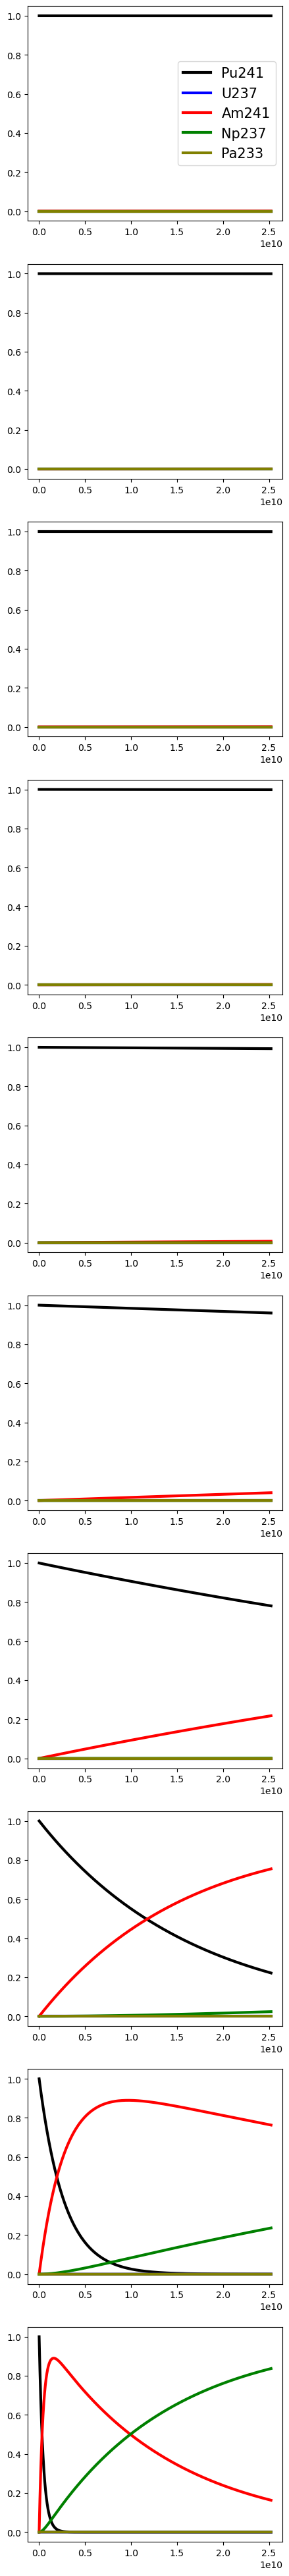

In [6]:
lams = np.abs(A.diagonal())
true_stiff = lams.max() / lams.min()
init_stiff = 10.0
n_step = 10
steps = np.logspace(np.log10(init_stiff), np.log10(true_stiff), num = n_step)
print("stiffness steps: ", steps)
n = len(lams)

fig, axs = plt.subplots(n_step, 1, figsize = (5, n_step * 5))
for i,stiffness in enumerate(steps):
    print("Solving stiffness {:.2e}".format(stiffness))
    t_final = 800 * year
    Aprime = reduce_stiffness(A, stiffness)
    tsRK, NsRK = RK45solve_full_trajectory(Aprime, N0, t_final,atol = 1e-8, rtol = 1e-8)
    for j in range(n):
        axs[i].plot(tsRK, NsRK[:,j], lw = 3, ls = "-", color = colors[j])
    
axs[0].legend(nucs, fontsize = 15)

plt.show()